In [1]:
# data stuff:
import pandas as pd
import numpy as np
import optuna
from tqdm import tqdm

from sklearn.model_selection import TimeSeriesSplit

# plotting stuff:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

# stats stuff:
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.regression.linear_model import yule_walker

# silence!
import warnings
warnings.filterwarnings("ignore")

---
## The SARIMAX Model:

The SARIMA models adds a "seasonality" effect to the univariate models seem previously, namely, the ARIMA model. It also adds an external variable to control for other factors that might affect the forecast. 

See page 127 of "Advanced Forecasting with Python".

---

### Load data and aggregate weekly sales across all stores:
Below we use the "IsHoliday" column as the external variable (i.e. the "X" in SARIMAX).

In [15]:
data = pd.read_csv('data/walmart_train.csv', usecols=['Date', 'Weekly_Sales', 'IsHoliday'])
data['IsHoliday'] = data['IsHoliday'].apply(float)
data = data.groupby('Date')[['Weekly_Sales', 'IsHoliday']].sum()
data['IsHoliday'] = (data['IsHoliday']>0).apply(float)
data

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,49750740.50,0.0
2010-02-12,48336677.63,1.0
2010-02-19,48276993.78,0.0
2010-02-26,43968571.13,0.0
2010-03-05,46871470.30,0.0
...,...,...
2012-09-28,43734899.40,0.0
2012-10-05,47566639.31,0.0
2012-10-12,46128514.25,0.0


### Check for correlation between weekly sales and holiday:

In [16]:
data.corr()

,Weekly_Sales,IsHoliday
Weekly_Sales,1.000000,0.172683
IsHoliday,0.172683,1.000000


As we can see, there's a small but not insignificant correlation between the weekly sales and the holiday indicator.

&nbsp;

### Find best parameters for SARIMA using Optuna:

In [18]:
# split data into train and test:
train = data['Weekly_Sales'][:-10]
test = data['Weekly_Sales'][-10:]

In [20]:
def objective_sarimax(trial):
    # define search space for each model's order:
    p=trial.suggest_int('p', 1, 3, step=1)
    i=trial.suggest_int('i', 1, 3, step=1)
    q=trial.suggest_int('q', 1, 3, step=1)
    
    # seasonal orders:
    P=trial.suggest_int('P', 1, 3, step=1)
    D=trial.suggest_int('D', 1, 3, step=1)
    Q=trial.suggest_int('Q', 1, 3, step=1)
    seasonal_order=52

    # initialize model and fit:
    try:
        model=sm.tsa.statespace.SARIMAX(endog=data['Weekly_Sales'][:-10],
                                        exog=data['IsHoliday'][:-10],
                                        order=(p,i,q),
                                        seasonal_order=(P,D,Q,seasonal_order))
        mdl = model.fit(disp=False)

        # predict on the fold:
        preds = mdl.forecast(steps=10, 
                             exog=data['IsHoliday'][-10:])

        # obtain residuals and evaluate using r-squared:
        score = r2_score(test, preds)
        
        # delete fitted models after eval:
        del model
        del mdl
        
    except:
        print('errored')

    return score

In [21]:
# find optimal params (orders) that will maximize R-squared value:
study=optuna.create_study(direction="maximize")
study.optimize(objective_sarimax, n_trials=25)

[I 2022-06-08 07:05:05,262] A new study created in memory with name: no-name-60a87e48-28ee-497e-8755-48b693365425
[I 2022-06-08 07:08:31,713] Trial 0 finished with value: -5.577602765884765 and parameters: {'p': 2, 'i': 3, 'q': 2, 'P': 1, 'D': 2, 'Q': 2}. Best is trial 0 with value: -5.577602765884765.
[I 2022-06-08 07:13:25,089] Trial 1 finished with value: -3.439242112439315 and parameters: {'p': 2, 'i': 3, 'q': 2, 'P': 1, 'D': 1, 'Q': 3}. Best is trial 1 with value: -3.439242112439315.
[I 2022-06-08 07:19:33,134] Trial 2 finished with value: 0.6257968357747647 and parameters: {'p': 2, 'i': 2, 'q': 3, 'P': 3, 'D': 1, 'Q': 3}. Best is trial 2 with value: 0.6257968357747647.
[I 2022-06-08 07:21:08,156] Trial 3 finished with value: 0.7377203410387214 and parameters: {'p': 1, 'i': 1, 'q': 3, 'P': 1, 'D': 1, 'Q': 2}. Best is trial 3 with value: 0.7377203410387214.
[I 2022-06-08 07:21:54,178] Trial 4 finished with value: 0.7486986119195517 and parameters: {'p': 1, 'i': 2, 'q': 1, 'P': 2, '

### Obtain best parameters from the optimization study:

In [22]:
# optimal result and corresponding params:
trial=study.best_trial

# top r-squared value:
trial_value = np.round(trial.value, 2)

print(f"R-squared: {trial_value}")
print("best params for SARIMAX: {}".format(trial.params))

R-squared: 0.75
best params for SARIMAX: {'p': 1, 'i': 2, 'q': 1, 'P': 2, 'D': 1, 'Q': 2}


### Explore results with best params:

In [23]:
# fit:
model=sm.tsa.statespace.SARIMAX(train, order=(1,2,1), seasonal_order=(2,1,2,52))
mdl = model.fit(disp=False)

# predict and evaluate:
preds = mdl.forecast(steps=10)
score = r2_score(test, preds)

### Plot:

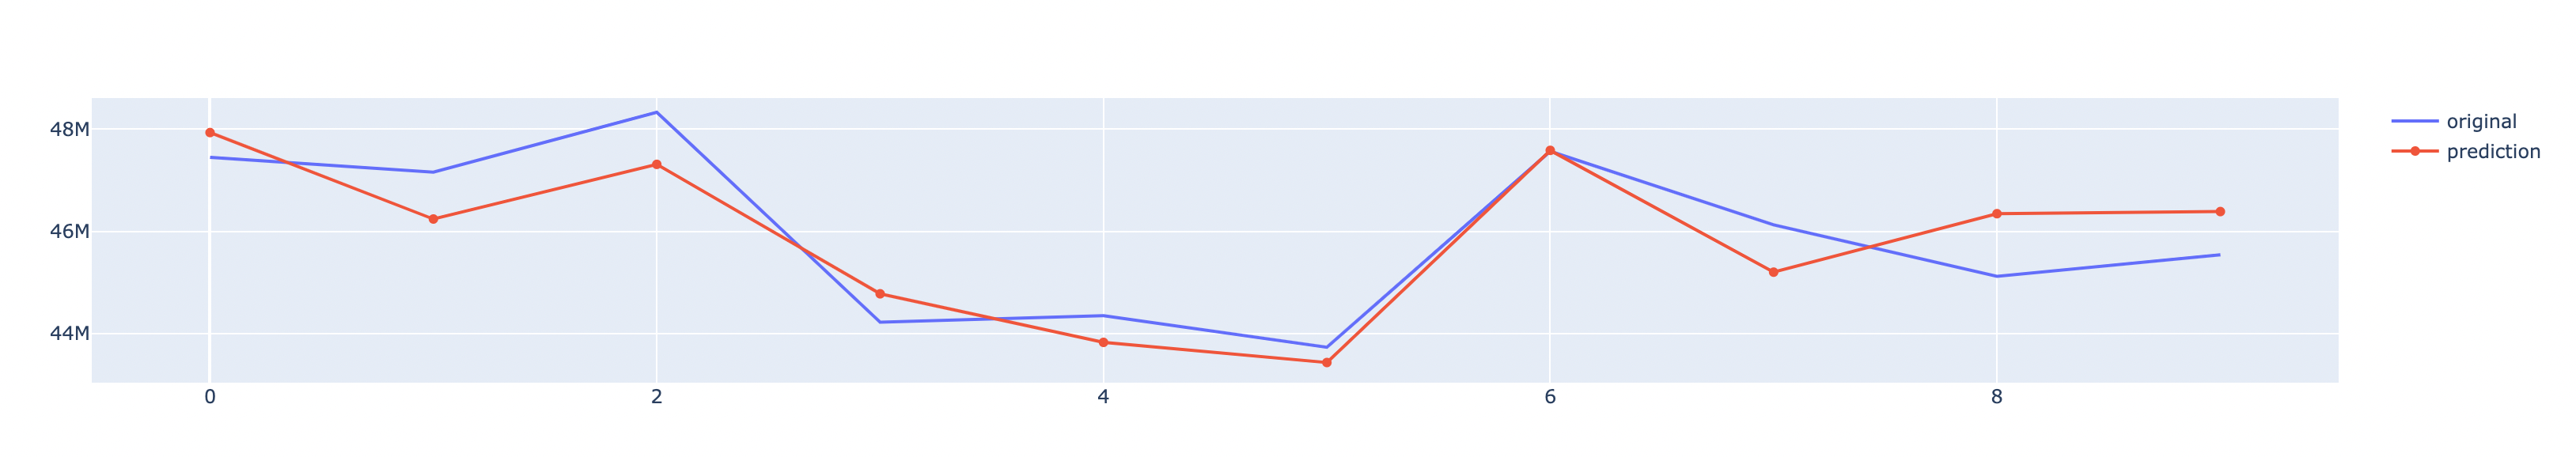

In [26]:
# plot:
fig = go.Figure()
# original
fig.add_trace(go.Scatter(y=test, mode='lines', name='original'))

# predicted:
fig.add_trace(go.Scatter(y=preds, mode='lines+markers', name='prediction'))
Image(filename='./images/ch8_finalfit.png', width=1600)

**Note:** the model above with r-squared value of 0.75 using the optimal parameters obtained with optuna beat the model shown in the text ("Advanced Forecasting with Python" page: 130) by 0.016 points (r-score = 0.734).